# Aleket Faster R-CNN training notebook

In [ ]:
%pip install pillow
%pip install numpy<2.0
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124
%pip install matplotlib
%pip install gdown
%pip install tqdm

from IPython.display import clear_output

clear_output(wait=False)

print("ALL DEPENDENCIES INSTALLED")

In [1]:
# IMPORTS

# Standard Library
import random

# Third-Party Libraries
import numpy as np
from matplotlib import pyplot as plt
# Torch
import torch

# Utils
from aleket_dataset import AleketDataset, download_dataset
from utils import split_dataset
from training_and_evaluation import train,parse_params,TrainParams
from utils import get_model
from dataset_statisics import visualize_example_bboxes

In [89]:
# Device Selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Random Seed for Reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
np_generator = np.random.default_rng(SEED)

# Dataset split
DATASET_FRACTION = 0.1
VALIDATION_FRACTION = 0.2
dataset = AleketDataset(download_dataset("dataset_patched", ""), img_size=1024)
train_set, val_set = split_dataset(dataset, DATASET_FRACTION, VALIDATION_FRACTION, np_generator)

def augment_example(dataset):
    examples = visualize_example_bboxes(dataset, image_ids_to_visualize=range(4))
    fig=plt.figure(figsize=(15, 3))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(examples[i-1])
    plt.show()

Using device: cuda
Dataset loaded from dataset_patched


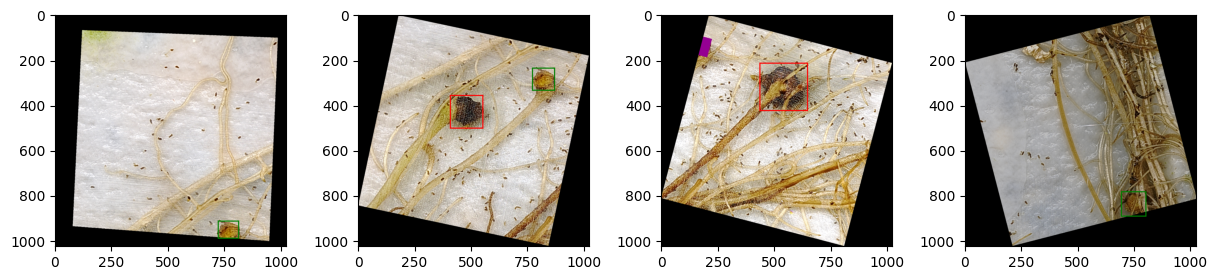


Epoch 1/100; Learning rate: 0.001


Training batches:   0%|          | 0/33 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [90]:

model = get_model(device)
params = TrainParams()
params.load("default.json")

parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

train(model, dataset, params, device, checkpoints=True)


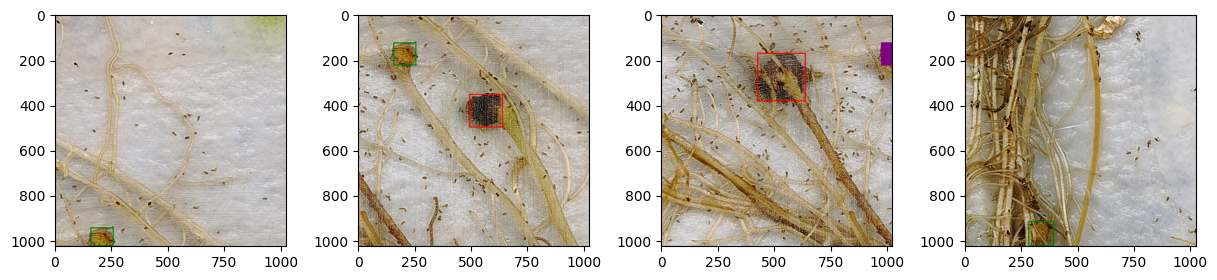

In [85]:
model = get_model(device)
params = TrainParams()
params.load("augment1.json")

parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

train(model, dataset, params, device, checkpoints=True)

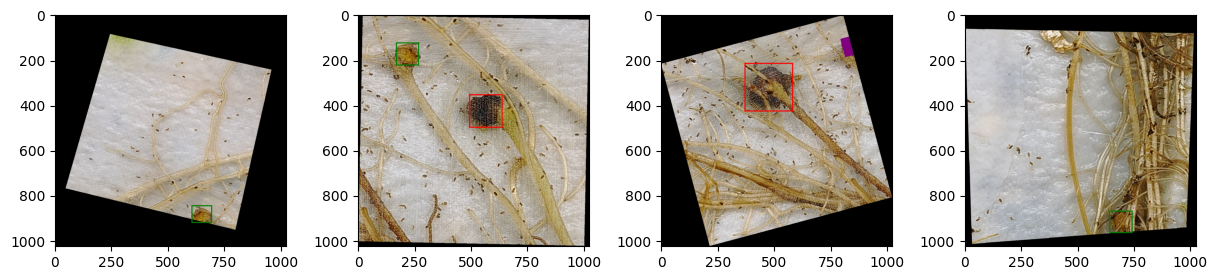

In [86]:
model = get_model(device)
params = TrainParams()
params.load("augment2.json")

parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

train(model, dataset, params, device, checkpoints=True)

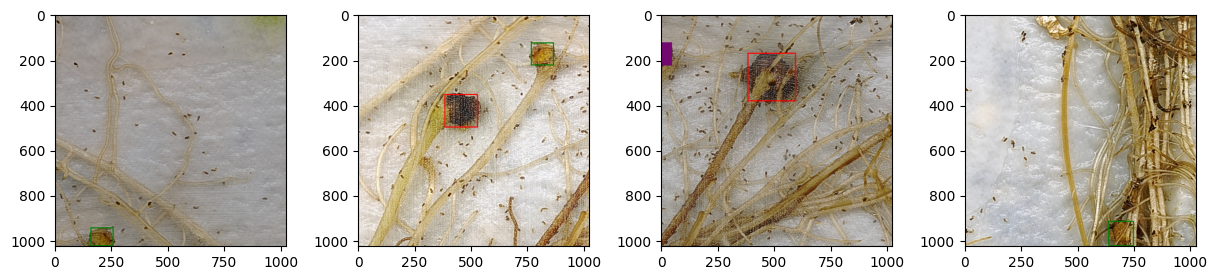

In [87]:
model = get_model(device)
params = TrainParams()
params.load("augment3.json")

parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

train(model, dataset, params, device, checkpoints=True)